In [1]:
%matplotlib inline
import player as data_pl
import team as data_te
import game as data_ga
import utils as anal_ut
import multiprocessing as mp
import numpy as np
import scipy
import scipy.stats as scst
import datetime
from numpy import linalg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.colors as colors
import pandas as pd
import time
from sklearn import cluster
from sklearn import linear_model
from collections import Counter
import math
import statsmodels.api as sm
import urllib2
import re
import os
import unicodedata

# Read in Player Parameters

In [2]:
today = datetime.datetime.now().date()
# today -= datetime.timedelta(days=1)
filename = 'Parameters/player_parameters_%s.csv' % today

player_params = pd.read_csv(filename, index_col=False)
player_params = player_params.set_index('PERSON_ID')
player_params

alpha_AST   alpha_BLK  alpha_STL   alpha_TOV  alpha_OREB  \
PERSON_ID                                                              
203112      25.099371   10.420361  11.570021   22.164406   31.613440   
203919      21.261001    8.022084  25.225571   22.824432   10.717975   
203500      29.060009   45.977284  14.371012   34.009478   76.684036   
201167      40.389566    1.906461   6.494064   25.246763    8.754399   
201582      25.057089   29.934875  15.077046   40.303089   61.483859   
202332      30.811752   38.319219  18.751634   35.105065   54.598611   
200746      42.682918   24.243423  11.741429   39.573562   65.815210   
1626146      2.261001    3.022084   6.225571    7.824432    3.717975   
202730      47.443748   24.341385  11.591787   29.701559   74.618371   
2754        38.418174   11.599054  59.241224   36.235872   49.023102   
202329      49.163455   30.094987  27.488349   47.543001   51.906018   
200811      32.831769   33.328231  19.842318   37.798110   72.617797   
2365        14.245565   24.323444   9.702845   16.844341   31.638623   
101187      17.501669    1.244177  11.401037   12.863143    6.824636   
202341      31.394739    5.559748  15.906091   26.603882   12.366378   
1626147      5.261001    3.022084   8.225571   13.824432    3.717975   
203937      40.644916   13.798376  25.987772   21.257993    8.693199   
201583      33.854828   12.344524  16.990543   41.314441   61.637297   
203507      70.269852   28.188428  26.850632   59.820079   33.288786   
2546        85.234804   14.737262  27.559607   59.369030   41.551417   
201202      12.568923   71.100047  20.612128   25.523230   66.579377   
2772        55.844762    6.022849  49.157811   47.132483   23.108201   
201589      38.242374   24.758480  27.559550   31.391036   46.552707   
201600      12.606138   14.587424   7.390707   28.345818   50.640432   
201571     103.738253    1.548152  18.984644   47.649442    7.559418   
202337      29.401284   10.365109  11.064347   22.174680   15.166659   
203946       3.261001    2.022084   8.225571    9.824432    8.717975   
2571        77.754222    7.611339  35.954165   39.942587   17.618935   
200826     139.224473    1.220297  13.714964   51.382324   15.072191   
200745      25.354227   19.884930   3.800582   35.553232   30.532397   
...               ...         ...        ...         ...         ...   
202689     138.186833   18.969389  45.294361   52.285358   16.702124   
202322     199.190732   19.266095  45.313520   95.622184   15.288249   
203933      23.276462    9.880885  21.798168   30.472938   44.804209   
201228      78.055189    2.484551  24.109008   31.381443    9.286430   
101110      28.662177    3.005836  11.840202   27.484980   14.176818   
201603      36.997237    1.635679  12.360854   31.856908   11.304165   
2561        69.136258   14.200947  15.965342   44.957361   29.790065   
201566     254.584775    8.097665  63.156682  132.991959   53.049907   
202355       6.166346  108.456840  19.499713   50.310603   88.670798   
203963       8.261001    3.022084  11.225571   13.824432   11.717975   
203952      47.394244   16.152011  21.312579   54.561875   41.704272   
203912      10.261001    2.022084   9.225571   16.824432    2.717975   
101114     162.231836    6.755633  34.201858   57.384482    6.500733   
202682      24.464580    5.733425  17.890189   26.717592   19.433368   
101150      64.443957    4.725892  24.943129   39.619692    8.000116   
101107      42.237446   27.321874  22.818823   25.568116   37.052508   
2590       139.050649    6.429629  17.652518   63.581031    7.535693   
1626159     23.261001    4.022084  15.225571   29.824432   16.717975   
203481      24.359038   46.312865  17.282320   26.730801   53.179873   
1626174      5.261001    6.022084  10.225571    8.824432   10.717975   
1897        38.057023   15.543856  42.115731   29.987058   32.533341   
201148      15.028649   34.311311  13.820868   13.819514   40.319199   
1626153      2.261001    1.022084   6.225571    7.82

## Functions for Projections
- Converts param table rows into pd.Series of Rates
- Takes rates and minutes and projects all stats, fantasy scores

In [3]:
PlayerList = data_pl.PlayerList(season='2015-16', only_current=1).info()
PlayerList = PlayerList.set_index('PERSON_ID')

def params2rates(params):
    dic = {'alpha': {}, 'beta': {}}
    for key in params:
        param, st = key.split('_')
        val = params[key].tolist()[0]
        dic[param][st] = val
    tmp = pd.DataFrame(dic)
    
    lm = []
    for st in ('AST','BLK','OREB','DREB','STL','TOV','FG2A','FG3A','FTA'):
        lm.append(tmp.alpha.loc[st] / tmp.beta.loc[st])
    
    p = []
    for st in ('FG2%','FG3%','FT%'):
        p.append(tmp.alpha.loc[st] / (tmp.alpha.loc[st] + tmp.beta.loc[st]))
    
    lm.extend(p)
    return pd.Series(lm, index=('AST','BLK','OREB','DREB','STL','TOV','FG2A','FG3A','FTA','FG2%','FG3%','FT%'))

def rates_mins2projs(rates, mins):
    p = 0.0
    for pt in range(15):
        for p3 in range(15):
            p += scst.poisson.sf((10-pt-3*p3)/2-1, mins*rates['FG2%']*rates['FG2A']) \
                * scst.poisson.pmf(pt, mins*rates['FT%']*rates['FTA']) \
                * scst.poisson.pmf(p3, mins*rates['FG3%']*rates['FG3A'])
    probs = {'PTS': p,
             'REB': scst.poisson.sf(9, mins*(rates['OREB']+rates['DREB'])),
             'AST': scst.poisson.sf(9, mins*rates['AST']),
             'STL': scst.poisson.sf(9, mins*rates['STL']),
             'BLK': scst.poisson.sf(9, mins*rates['BLK'])
            }
#     print pd.DataFrame(probs, index=['Prob(X >= 10)'])

    p2_2 = 0.0
    p3_2 = 0.0
    sts = probs.keys()
    for k, st in enumerate(sts):
        v = probs[st]
        for k2, st2 in enumerate(sts[k+1:]):
            v2 = probs[st2]
            p2_2 += v*v2
            for st3 in sts[k+k2+2:]:
                v3 = probs[st3]
                p3_2 += v*v2*v3
#     print 'Prob(Double-Double or Triple-Double) =', p2_2
#     print 'Prob(Triple-Double) =', p3_2
    
    projs = mins * rates[['AST','BLK','FG2A','FG3A','FTA','OREB','DREB','STL','TOV']]
    projs['REB'] = projs.OREB + projs.DREB
    projs['FGM'] = rates['FG2%']*projs['FG2A'] + rates['FG3%']*projs['FG3A']
    projs['FG3M'] = rates['FG3%']*projs['FG3A']
    projs['FGA'] = projs['FG2A'] + projs['FG3A']
    del projs['FG2A']
    projs['FTM'] = projs['FTA'] * rates['FT%']
    projs['PTS'] = 2*projs['FGM'] + projs['FG3M'] + projs['FTM']
    projs['MIN'] = mins
    
    projs['DD'] = p2_2 - p3_2
    projs['TD'] = p3_2
    
    projs['FD'] = projs.PTS + 1.2*projs.REB + 1.5*projs.AST + 2*projs.BLK + 2*projs.STL - projs.TOV
    projs['DK'] = projs.PTS + .5*projs.FG3M + 1.25*(projs.OREB+projs.DREB) + 1.5*projs.AST + 2*projs.BLK + 2*projs.STL \
                - .5*projs.TOV + 1.5*projs.DD + 3*projs.TD
    
    projs['FD_std'] = np.sqrt(
        4*(rates['FG2%']*rates['FG2A']*mins + rates['FG2%']**2*rates['FG2A']*mins + rates['FG2%']*(1-rates['FG2%'])*(rates['FG2A']*mins)**2 )+\
        9*(rates['FG3%']*(1-rates['FG3%'])*rates['FG3A']*mins + rates['FG3%']**2*rates['FG3A']*mins + rates['FG3%']*(1-rates['FG3%'])*(rates['FG3A']*mins)**2 )+\
        1*(rates['FT%']*(1-rates['FT%'])*rates['FTA']*mins + rates['FT%']**2*rates['FTA']*mins + rates['FT%']*(1-rates['FT%'])*(rates['FTA']*mins)**2 )+\
        1.44*(rates.OREB+rates.DREB) + 2.25*rates.AST + 4*rates.BLK + 4*rates.STL + rates.TOV)
    
    projs['DK_std'] = np.sqrt(
        4*(rates['FG2%']*(1-rates['FG2%'])*rates['FG2A']*mins + rates['FG2%']**2*rates['FG2A']*mins + rates['FG2%']*(1-rates['FG2%'])*(rates['FG2A']*mins)**2 )+\
        12.25*(rates['FG3%']*(1-rates['FG3%'])*rates['FG3A']*mins + rates['FG3%']**2*rates['FG3A']*mins + rates['FG3%']*(1-rates['FG3%'])*(rates['FG3A']*mins)**2 )+\
        1*(rates['FT%']*(1-rates['FT%'])*rates['FTA']*mins + rates['FT%']**2*rates['FTA']*mins + rates['FT%']*(1-rates['FT%'])*(rates['FTA']*mins)**2 )+\
        1.5625*(rates.OREB+rates.DREB) + 2.25*rates.AST + 4*rates.BLK + 4*rates.STL + .25*rates.TOV +\
        2.25*projs.DD*(1-projs.DD) + 9*projs.TD*(1-projs.TD))
    
    return projs
                  

# Get Rates and MIN projections to compute FD and DK Projections

##### Set Custom MIN projection rather than using the season median

In [4]:
## Adjust names form the FD Players List to work with the NBA API
FD_NAME_CORRECTIONS = {
    'Brad Beal': 'Bradley Beal',
    'C.J. McCollum': 'CJ McCollum',
    'J.J. Redick': 'JJ Redick',
    'C.J. Miles': 'CJ Miles',
    'P.J. Tucker': 'PJ Tucker',
    'Nene Hilario': 'Nene',
    'Patrick Mills': 'Patty Mills',
    'T.J. Warren': 'TJ Warren',
    'Luc Richard Mbah a Moute': 'Luc Mbah a Moute',
    'C.J. Watson': 'CJ Watson',
    'C.J. Wilcox': 'CJ Wilcox',
    'Roy Devyn Marble': 'Devyn Marble',
    'K.J. McDaniels': 'KJ McDaniels',
    'T.J. McConnell': 'TJ McConnell',
    'Chuck Hayes': 'Charles Hayes',
    'Joseph Young': 'Joe Young',
    'Glenn Robinson III': 'Glenn Robinson',
    'Louis Amundson': 'Lou Amundson',
    'J.J. Hickson': 'JJ Hickson',
    'P.J. Hairston': 'PJ Hairston',
    'Louis Williams': 'Lou Williams',
    'Ishmael Smith': 'Ish Smith',
    'Phil (Flip) Pressey': 'Phil Pressey',
}

DK_NAME_CORRECTIONS = {
    'Brad Beal': 'Bradley Beal',
    'C.J. McCollum': 'CJ McCollum',
    'J.J. Redick': 'JJ Redick',
    'C.J. Miles': 'CJ Miles',
    'P.J. Tucker': 'PJ Tucker',
    'Nene Hilario': 'Nene',
    'Patrick Mills': 'Patty Mills',
    'T.J. Warren': 'TJ Warren',
    'Luc Richard Mbah a Moute': 'Luc Mbah a Moute',
    'C.J. Watson': 'CJ Watson',
    'C.J. Wilcox': 'CJ Wilcox',
    'Roy Devyn Marble': 'Devyn Marble',
    'K.J. McDaniels': 'KJ McDaniels',
    'T.J. McConnell': 'TJ McConnell',
    'Chuck Hayes': 'Charles Hayes',
    'Joseph Young': 'Joe Young',
    'Glenn Robinson III': 'Glenn Robinson',
    'Louis Amundson': 'Lou Amundson',
    'Denis Schroder': 'Dennis Schroder',
    'Manu Gin**bili' : 'Manu Ginobili',
    'Jos** Calder**n': 'Jose Calderon',
    'R.J. Hunter': 'RJ Hunter',
    'Kelly Oubre Jr.': 'Kelly Oubre',
    'J.J. Hickson': 'JJ Hickson',
    'P.J. Hairston': 'PJ Hairston',
    'Cristiano Fel**cio': 'Cristiano Felicio',
    'J.J. Barea': 'Jose Juan Barea',
    'Louis Williams': 'Lou Williams',
    'Ishmael Smith': 'Ish Smith',
    'Phil (Flip) Pressey': 'Phil Pressey',
    'Kevin Mart**n': 'Kevin Martin',
    'Andr** Miller': 'Andre Miller',
}


In [5]:
pid = data_pl.get_player('Andre','Miller', season='2015-16', only_current=1, just_id=True)
data_pl.PlayerGameLogs(pid, season='2015-16').info()

SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0     22015       1889  0021500247  NOV 29, 2015    MIN @ LAC  L   21    4   
1     22015       1889  0021500237  NOV 27, 2015    MIN @ SAC  W   19    4   
2     22015       1889  0021500206  NOV 23, 2015  MIN vs. PHI  W    9    0   
3     22015       1889  0021500146  NOV 15, 2015  MIN vs. MEM  L   34    4   
4     22015       1889  0021500127  NOV 13, 2015    MIN @ IND  L   23    4   
5     22015       1889  0021500125  NOV 12, 2015  MIN vs. GSW  L   22    5   
6     22015       1889  0021500111  NOV 10, 2015  MIN vs. CHA  L    3    0   
7     22015       1889  0021500101  NOV 09, 2015    MIN @ ATL  W    5    0   
8     22015       1889  0021500071  NOV 05, 2015  MIN vs. MIA  L    4    0   

   FGA  FG_PCT       ...         DREB  REB  AST  STL  BLK  TOV  PF  PTS  \
0    7   0.571       ...            1    1    4    1    0    3   1   11   
1    4   1.000       ...            1    1    4    1    0    0   3   12   
2    1   0.000       ...            1    1    4    0    0    2   1    0   
3    8   0.500       ...            2    3    8    3    0    2   4    8   
4    5   0.800       ...            3    4    5    1    0    3   5   10   
5    8   0.625       ...            1    3    4    0    0    2   4   11   
6    0   0.000       ...            0    0    0    0    0    0   0    0   
7    1   0.000       ...            0    0    1    1    0    1   1    0   
8    0   0.000       ...            0    0    1    1    0    0   0    0   

   PLUS_MINUS  VIDEO_AVAILABLE  
0          -8                1  
1          12                1  
2          -4                1  
3         -17                1  
4          12                1  
5          12                1  
6          -9                1  
7          -1                1  
8           9                1  

[9 rows x 27 columns]

## Load players from FanDuel PlayerList

In [6]:
pl = pd.read_csv('PlayerLists/pl_fd_nba_%02d_%02d_%d.csv' % (today.month, today.day, today.year))
del pl['Unnamed: 12']
del pl['Unnamed: 13']
pl = pl.rename(columns={'Position':'Pos', 'Opponent':'Opp', 'Injury Indicator':'Status'})

# Pace Adjustments

### Table of All Team GameLogs this season

In [7]:
table = pd.DataFrame()
for team, dic in data_te.TEAMS.iteritems():
    tid = dic['id']
    gl = data_te.TeamGameLogs(tid, season='2015-16').info()
    table = table.append(gl, ignore_index=True)
table

Team_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  FGA  \
0    1610612749  0021500246  NOV 29, 2015    MIL @ CHA  L  240   33   82   
1    1610612749  0021500228  NOV 27, 2015    MIL @ ORL  L  240   31   74   
2    1610612749  0021500221  NOV 25, 2015  MIL vs. SAC  L  240   42   88   
3    1610612749  0021500205  NOV 23, 2015  MIL vs. DET  W  240   43   83   
4    1610612749  0021500190  NOV 21, 2015    MIL @ IND  L  240   34   79   
5    1610612749  0021500176  NOV 19, 2015    MIL @ CLE  L  240   38   73   
6    1610612749  0021500158  NOV 17, 2015    MIL @ WAS  L  240   31   72   
7    1610612749  0021500141  NOV 14, 2015  MIL vs. CLE  W  290   43  102   
8    1610612749  0021500121  NOV 11, 2015    MIL @ DEN  L  240   42   79   
9    1610612749  0021500110  NOV 10, 2015  MIL vs. BOS  L  240   30   73   
10   1610612749  0021500089  NOV 07, 2015  MIL vs. BKN  W  240   37   82   
11   1610612749  0021500079  NOV 06, 2015    MIL @ NYK  W  240   35   81   
12   1610612749  0021500065  NOV 04, 2015  MIL vs. PHI  W  240   35   86   
13   1610612749  0021500047  NOV 02, 2015    MIL @ BKN  W  240   38   73   
14   1610612749  0021500042  NOV 01, 2015    MIL @ TOR  L  240   29   69   
15   1610612749  0021500027  OCT 30, 2015  MIL vs. WAS  L  240   42   82   
16   1610612749  0021500012  OCT 28, 2015  MIL vs. NYK  L  240   30   86   
17   1610612744  0021500245  NOV 28, 2015  GSW vs. SAC  W  240   39   80   
18   1610612744  0021500236  NOV 27, 2015    GSW @ PHX  W  240   46   81   
19   1610612744  0021500214  NOV 24, 2015  GSW vs. LAL  W  240   45   92   
20   1610612744  0021500200  NOV 22, 2015    GSW @ DEN  W  240   47   89   
21   1610612744  0021500187  NOV 20, 2015  GSW vs. CHI  W  240   39   79   
22   1610612744  0021500177  NOV 19, 2015    GSW @ LAC  W  240   38   73   
23   1610612744  0021500164  NOV 17, 2015  GSW vs. TOR  W  240   43   80   
24   1610612744  0021500144  NOV 14, 2015  GSW vs. BKN  W  265   43   97   
25   1610612744  0021500125  NOV 12, 2015    GSW @ MIN  W  240   48   89   
26   1610612744  0021500120  NOV 11, 2015    GSW @ MEM  W  240   36   75   
27   1610612744  0021500104  NOV 09, 2015  GSW vs. DET  W  240   43   91   
28   1610612744  0021500092  NOV 07, 2015    GSW @ SAC  W  240   38   92   
29   1610612744  0021500083  NOV 06, 2015  GSW vs. DEN  W  240   46   93   
..          ...         ...           ...          ... ..  ...  ...  ...   
476  1610612754  0021500190  NOV 21, 2015  IND vs. MIL  W  240   47   91   
477  1610612754  0021500167  NOV 18, 2015    IND @ PHI  W  240   42   92   
478  1610612754  0021500153  NOV 16, 2015    IND @ CHI  L  240   35   87   
479  1610612754  0021500127  NOV 13, 2015  IND vs. MIN  W  240   41   86   
480  1610612754  0021500116  NOV 11, 2015    IND @ BOS  W  240   38   79   
481  1610612754  0021500099  NOV 09, 2015  IND vs. ORL  W  240   34   77   
482  1610612754  0021500094  NOV 08, 2015    IND @ CLE  L  240   39   90   
483  1610612754  0021500080  NOV 06, 2015  IND vs. MIA  W  240   36   80   
484  1610612754  0021500060  NOV 04, 2015  IND vs. BOS  W  240   35   91   
485  1610612754  0021500054  NOV 03, 2015    IND @ DET  W  240   38   88   
486  1610612754  0021500033  OCT 31, 2015  IND vs. UTA  L  240   28   70   
487  1610612754  0021500018  OCT 29, 2015  IND vs. MEM  L  240   37   78   
488  1610612754  0021500009  OCT 28, 2015    IND @ TOR  L  240   32   86   
489  1610612740  0021500243  NOV 28, 2015    NOP @ UTA  L  240   29   69   
490  1610612740  0021500238  NOV 27, 2015    NOP @ LAC  L  240   34   94   
491  1610612740  0021500225  NOV 25, 2015    NOP @ PHX  W  240   42   81   
492  1610612740  0021500198  NOV 22, 2015  NOP vs. PHX  W  240   39   85   
493  1610612740  0021500182  NOV 20, 2015  NOP vs. SAS  W  240   40   88   
494  1610612740  0021500171  NOV 18, 2015    NOP @ OKC  L  240   43   95   
495  1610612740  0021500163  NOV 17, 2015  NOP vs. DEN  L  240   41   83   
496  1610612740  0021500145  NOV 15, 2015    NOP @ NYK  

In [8]:
dic = {'Team_ID': [], 'OREB': [], 'DREB': [], 'NREB': [], 'OPP_OREB': [], 'OPP_DREB': [], 'OMISS': [], 'DMISS': [], 'MIN': [], 'POS': []}
for tid in np.unique(table.Team_ID):
    gids = np.unique(table[table.Team_ID==tid].Game_ID)
    for gid in gids:
        sub = table[(table.Team_ID==tid) & (table.Game_ID==gid)]
        omiss = np.sum(sub.FGA - sub.FGM + .44*(sub.FTA - sub.FTM))
#         omiss = np.sum(sub.FGA - sub.FGM)
        oreb = np.sum(sub.OREB)
        dreb = np.sum(sub.DREB)
        subo = table[(table.Team_ID!=tid) & (table.Game_ID==gid)]
        dmiss = np.sum(subo.FGA - subo.FGM + .44*(subo.FTA - subo.FTM))
#         dmiss = np.sum(sub.FGA - sub.FGM)
        opp_oreb = np.sum(subo.OREB)
        opp_dreb = np.sum(subo.DREB)
        nreb = dmiss - opp_oreb - dreb
        
        mins = np.sum(subo.MIN)
        pos = 0.5 * ((sub.FGA.sum() + 0.4 * sub.FTA.sum() - 1.07 * (sub.OREB.sum() / (sub.OREB.sum() + subo.DREB.sum())) * (sub.FGA.sum() - sub.FGM.sum()) + sub.TOV.sum()) +\
                     (sub.FGA.sum() + 0.4 * subo.FTA.sum() - 1.07 * (subo.OREB.sum() / (subo.OREB.sum() + sub.DREB.sum())) * (subo.FGA.sum() - subo.FGM.sum()) + subo.TOV.sum()))
        
        dic['Team_ID'].append(tid)
        dic['OREB'].append(oreb)
        dic['DREB'].append(dreb)
        dic['NREB'].append(nreb)
        dic['OPP_OREB'].append(opp_oreb)
        dic['OPP_DREB'].append(opp_dreb)
        dic['OMISS'].append(omiss)
        dic['DMISS'].append(dmiss)
        dic['MIN'].append(mins)
        dic['POS'].append(pos)
pd.DataFrame(dic)

DMISS  DREB  MIN   NREB  OMISS  OPP_DREB  OPP_OREB  OREB    POS  \
0    61.64    33  240   5.64  46.32        36        23     7  105.2   
1    55.88    32  240   7.88  44.52        32        16     7  110.4   
2    53.32    37  240   3.32  49.20        41        13     8  106.5   
3    54.44    39  240   6.44  51.44        36         9     9  104.8   
4    50.20    35  240   2.20  55.20        36        13    16  114.1   
5    48.32    28  240   6.32  41.20        29        14     6   99.4   
6    43.32    35  240   2.32  38.20        26         6     6  102.3   
7    40.88    29  240   3.88  49.00        33         8    10  117.4   
8    35.76    23  240   4.76  42.44        32         8     4  109.8   
9    48.20    36  240   4.20  45.76        32         8     8  107.7   
10   61.44    30  240  14.44  42.20        33        17     5   95.4   
11   39.20    25  240   4.20  40.32        30        10     8   98.8   
12   49.64    36  240   4.64  44.76        35         9     8   96.9   
13   48.88    33  240   2.88  53.64        39        13    12  112.9   
14   45.32    26  240   8.32  55.32        40        11    12  107.8   
15   50.64    37  240   3.64  36.32        23        10     6  107.6   
16   51.08    38  240   6.08  55.40        38         7    15  107.3   
17   45.88    34  240   6.88  41.76        32         5     6   97.9   
18   45.44    31  240   2.44  52.20        37        12    12  110.6   
19   50.32    31  240   5.32  46.44        32        14    10  114.5   
20   48.20    31  240   8.20  56.96        44         9     7  119.2   
21   50.08    29  240  11.08  64.32        41        10    16  122.8   
22   59.08    34  240   4.08  49.76        32        21    15  109.7   
23   54.20    38  240   6.20  55.20        35        10    15  126.7   
24   45.64    31  240   5.64  49.32        32         9    14  108.9   
25   45.84    28  240   7.84  48.96        31        10     8  107.6   
26   42.20    33  240   4.20  61.44        30         5    17  122.4   
27   51.64    35  240   6.64  46.08        24        10    12  109.8   
28   53.84    33  240   6.84  51.20        32        14    16  121.5   
29   39.40    29  240   3.40  56.64        32         7    14  119.3   
..     ...   ...  ...    ...    ...       ...       ...   ...    ...   
476  57.20    41  240   5.20  44.92        35        11     6   99.3   
477  37.64    28  240   2.64  52.08        33         7    18  119.5   
478  48.88    29  240   6.88  47.64        28        13    12  108.6   
479  39.64    31  240   1.64  57.20        39         7    14  114.8   
480  44.64    31  240   2.64  46.28        31        11    11  100.2   
481  48.40    34  240   7.40  64.08        39         7    12  119.8   
482  45.52    37  240   5.52  50.64        37         3    11  107.7   
483  47.52    37  240   4.52  48.32        34         6     8  110.1   
484  42.64    30  240   3.64  45.64        33         9     8   99.2   
485  41.32    26  240   3.32  61.76        33        12    22  113.7   
486  49.20    36  240   3.20  57.44        33        10    18  112.6   
487  43.76    25  240   6.76  60.76        46        12    13  112.2   
488  47.32    32  240   8.32  72.28        44         7    19  124.9   
489  37.44    32  240   3.44  54.08        39         2    11  104.5   
490  49.20    41  240   0.20  53.32        37         8    13  111.5   
491  51.44    36  240   6.44  54.44        39         9     9  102.8   
492  48.20    40  240   4.20  44.44        29         4    12  107.7   
493  51.32    40  240   3.32  46.32        36         8     8  109.8   
494  39.52    27  240   6.52  43.84        36         6     6   97.3   
495  46.20    30  240   6.20  43.08        38        10     4  106.2   
496  44.88    26  240   7.88  53.84        41        11     7  101.5   
497  50.08    36  240   4.08  59.88        47        10     9  112.1   
498  54.88    30  240   8.88  43.76        30        16     7  102.5   
499  53.44    34  240   9.44  49.52        35

In [9]:
tid2team = dict(zip(
    [int(data_te.TEAMS[team]['id']) for team in data_te.TEAMS.keys()], data_te.TEAMS.keys()))
tid2team

{1610612737: 'ATL',
 1610612738: 'BOS',
 1610612739: 'CLE',
 1610612740: 'NOP',
 1610612741: 'CHI',
 1610612742: 'DAL',
 1610612743: 'DEN',
 1610612744: 'GSW',
 1610612745: 'HOU',
 1610612746: 'LAC',
 1610612747: 'LAL',
 1610612748: 'MIA',
 1610612749: 'MIL',
 1610612750: 'MIN',
 1610612751: 'BKN',
 1610612752: 'NYK',
 1610612753: 'ORL',
 1610612754: 'IND',
 1610612755: 'PHI',
 1610612756: 'PHX',
 1610612757: 'POR',
 1610612758: 'SAC',
 1610612759: 'SAS',
 1610612760: 'OKC',
 1610612761: 'TOR',
 1610612762: 'UTA',
 1610612763: 'MEM',
 1610612764: 'WAS',
 1610612765: 'DET',
 1610612766: 'CHA'}

In [10]:
pt = pd.pivot_table(pd.DataFrame(dic), values=['DMISS','DREB','NREB','OMISS','OREB','OPP_DREB','OPP_OREB','MIN','POS'], index='Team_ID', aggfunc=np.sum)
pt['DREB%'] = pt.DREB / pt.DMISS
pt['OREB%'] = pt.OREB / pt.OMISS
pt['NREB%'] = pt.NREB / pt.DMISS
pt['MISS'] = pt.OMISS + pt.DMISS
pt['OPP_REB'] = pt.OPP_OREB + pt.OPP_DREB
pt['OPP_REB%'] = pt.OPP_REB / pt.MISS
pt['REB'] = pt.OREB + pt.DREB
pt['REB%'] = pt.REB / pt.MISS
pt['Team'] = [tid2team[tid] for tid in pt.index]
pt['OREB/MIN'] = pt.OREB / pt.MIN
pt['DREB/MIN'] = pt.DREB / pt.MIN
pt['REB/MIN'] = (pt.OREB + pt.DREB) / pt.MIN
pt['POS/MIN'] = pt.POS / pt.MIN
pt.sort('REB%', ascending=False)[['Team','DREB%','OREB%']]

Team     DREB%     OREB%
Team_ID                            
1610612759  SAS  0.740811  0.199183
1610612739  CLE  0.729187  0.222211
1610612760  OKC  0.666472  0.268129
1610612765  DET  0.712323  0.255965
1610612744  GSW  0.664087  0.232491
1610612762  UTA  0.695472  0.243269
1610612761  TOR  0.690878  0.228490
1610612756  PHX  0.716451  0.217640
1610612751  BKN  0.706381  0.220198
1610612750  MIN  0.700519  0.197294
1610612748  MIA  0.669609  0.208251
1610612758  SAC  0.686800  0.228876
1610612757  POR  0.671580  0.220804
1610612753  ORL  0.667787  0.231863
1610612743  DEN  0.682314  0.226470
1610612766  CHA  0.712207  0.168902
1610612742  DAL  0.697445  0.169123
1610612754  IND  0.662112  0.212557
1610612745  HOU  0.668807  0.222626
1610612752  NYK  0.644102  0.229686
1610612763  MEM  0.694756  0.200027
1610612738  BOS  0.645431  0.234323
1610612737  ATL  0.663812  0.186399
1610612764  WAS  0.678444  0.191593
1610612741  CHI  0.662593  0.175885
1610612746  LAC  0.647355  0.190697
1610612755  PHI  0.667074  0.190392
1610612740  NOP  0.688827  0.167477
1610612747  LAL  0.667808  0.180445
1610612749  MIL  0.617909  0.213806

## Compute Inherent Pace

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     4.824
Date:                Mon, 30 Nov 2015   Prob (F-statistic):           3.65e-12
Time:                        23:56:14   Log-Likelihood:                 112.38
No. Observations:                 253   AIC:                            -164.8
Df Residuals:                     223   BIC:                            -58.76
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             4.2054      0.079     53.233      0.0

PPM
SAC  4.495507
GSW  4.466690
OKC  4.425254
BOS  4.424875
CHI  4.404916
PHX  4.399766
WAS  4.314918
IND  4.292261
LAL  4.286291
NOP  4.272386
PHI  4.242098
BKN  4.233816
POR  4.224428
ORL  4.224331
HOU  4.223202
NYK  4.217079
DAL  4.207121
ATL  4.205397
DEN  4.188154
DET  4.156004
LAC  4.134382
MIN  4.127658
CHA  4.088086
CLE  4.049994
MIA  4.030703
SAS  3.982549
TOR  3.970105
MIL  3.863415
MEM  3.861859
UTA  3.820201

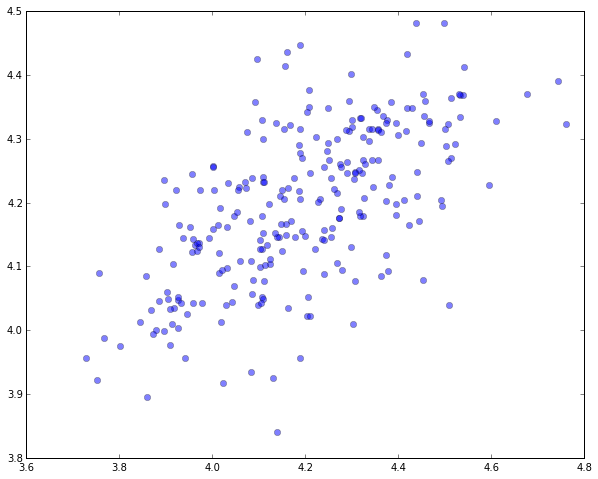

In [11]:
tids = pt.index.tolist()
indices = dict(zip(tids, range(30)))

gids = np.unique(table.Game_ID.tolist())
ngames = len(gids)

games = np.unique(pl[~np.isnan(pl.Played)].Game)

A = np.zeros((ngames, 30))
b = np.empty(ngames)

for k, gid in enumerate(gids):
    sub = table[table.Game_ID==gid]
    pos = 0.5 * \
        ((sub.FGA.sum() + 0.4 * sub.FTA.sum() - 1.07 * (sub.OREB.sum() / (sub.OREB.sum() + subo.DREB.sum()))\
        * (sub.FGA.sum() - sub.FGM.sum()) + sub.TOV.sum()) +\
        (sub.FGA.sum() + 0.4 * subo.FTA.sum() - 1.07 * (subo.OREB.sum() / (subo.OREB.sum() + sub.DREB.sum()))\
        * (subo.FGA.sum() - subo.FGM.sum()) + subo.TOV.sum()))

    mins = sub.MIN.tolist()[0]
    ppm = pos / (mins/5)
    
    b[k] = ppm
    for tid in sub.Team_ID:
        A[k, indices[tid]] = .5
        
res = sm.OLS(b, A).fit()
print res.summary()
plt.plot(b, res.fittedvalues, 'o', alpha=.5)

ppms = np.linalg.solve(A.T.dot(A), A.T.dot(b))
ppms = dict(zip(indices.keys(), [ppms[indices[k]] for k in indices.keys()]))
pd.DataFrame({'PPM': ppms.values()}, index=[tid2team[k] for k in ppms.keys()]).sort('PPM', ascending=False)

In [12]:
fix_team_abbrev = {
    'GS' : 'GSW',
    'NO' : 'NOP',
    'SA' : 'SAS',
    'NY' : 'NYK',
    'PHO': 'PHX',
}

team2ppmadj = {}
for game in games:
    A, H = game.split('@')
    try:
        A = fix_team_abbrev[A]
    except:
        pass
    try:
        H = fix_team_abbrev[H]
    except:
        pass
    
    a = ppms[int(data_te.TEAMS[A]['id'])]
    b = ppms[int(data_te.TEAMS[H]['id'])]
    mid = .5*(a+b)
    am = mid/ppms[int(data_te.TEAMS[A]['id'])]
    bm = mid/ppms[int(data_te.TEAMS[H]['id'])]
    team2ppmadj[A] = am
    team2ppmadj[H] = bm
team2ppmadj

{'ATL': 1.0261398652212317,
 'BOS': 0.9554595484351186,
 'CHI': 0.95205734815847143,
 'DAL': 1.03427347351539,
 'DEN': 0.9612312986888617,
 'DET': 1.0080843461654907,
 'GSW': 0.9276322199910626,
 'HOU': 0.99204428730534255,
 'LAC': 1.0108898407692906,
 'MIA': 1.0488961662104954,
 'MIL': 1.0420273964726006,
 'OKC': 0.97515882472596871,
 'POR': 0.9893422809573853,
 'SAC': 0.96792515891732478,
 'SAS': 1.0530271790037602,
 'UTA': 1.0846145082454848}

In [13]:
pt['O_Delta'] = pt['OREB%'] - pt['OREB%'].median()
pt['D_Delta'] = pt['DREB%'] - pt['DREB%'].median()

rtid2team = dict(zip(tid2team.values(),tid2team.keys()))

team2oreb_adj = {}
team2dreb_adj = {}

for game in games:
    A, H = game.split('@')
    try:
        atid = rtid2team[A]
    except KeyError:
        A = fix_team_abbrev[A]
        atid = rtid2team[A]
    try:
        htid = rtid2team[H]
    except KeyError:
        H = fix_team_abbrev[H]
        htid = rtid2team[H]
    delta_a_h = pt['O_Delta'].loc[atid] - pt['D_Delta'].loc[htid]
    delta_h_a = pt['O_Delta'].loc[htid] - pt['D_Delta'].loc[atid]
#     print game, delta_a_h, delta_h_a
#     print A, pt['OREB%'].loc[atid] + delta_a_h, pt['DREB%'].loc[atid] - delta_h_a
#     print H, pt['OREB%'].loc[htid] + delta_h_a, pt['DREB%'].loc[htid] - delta_a_h
    
    team2oreb_adj[A] =  1. + delta_a_h / pt['OREB%'].loc[atid]
    team2oreb_adj[H] =  1. + delta_h_a / pt['OREB%'].loc[htid]
    team2dreb_adj[A] =  1. - delta_h_a / pt['DREB%'].loc[atid]
    team2dreb_adj[H] =  1. - delta_a_h / pt['DREB%'].loc[htid]
print team2oreb_adj
team2dreb_adj

{'UTA': 1.1581410019460909, 'MIL': 0.9568788206613511, 'GSW': 0.98412125623264457, 'SAC': 0.95945415572455484, 'MIA': 1.1061658976547528, 'POR': 1.1482673327849977, 'ATL': 0.88849596405603781, 'BOS': 1.1024345030362594, 'DET': 1.1814609570790338, 'LAC': 0.88676267282260146, 'DAL': 0.65475777982474259, 'OKC': 1.2372233582828878, 'HOU': 0.86341223019988311, 'DEN': 1.2995985996814299, 'CHI': 0.39939849916972558, 'SAS': 0.97930867345606631}


{'ATL': 0.90417983462276053,
 'BOS': 0.96574516457874937,
 'CHI': 1.0062200347167327,
 'DAL': 1.013305647919478,
 'DEN': 1.0135121809123722,
 'DET': 1.0426884874910507,
 'GSW': 0.9420697186113357,
 'HOU': 0.93055133866565176,
 'LAC': 0.94942810924983934,
 'MIA': 0.96415411673177043,
 'MIL': 0.89019392325964564,
 'OKC': 1.0311853993963074,
 'POR': 1.0321540437784407,
 'SAC': 1.0850150713747866,
 'SAS': 1.1425960833542868,
 'UTA': 1.0053081487632116}

# Make Projections

In [14]:
person_ids = []
series = []
for row_ind in xrange(len(pl.Id)):
    row = pl.ix[row_ind]
    fname = row['First Name']
    lname = row['Last Name']
    
    status = row.Status
    
    try:
        name = FD_NAME_CORRECTIONS['%s %s' % (fname, lname)]
        spl = name.split(' ')
        fname = spl[0]
        lname = ' '.join(spl[1:])
    except KeyError:
        pass
        
    pid = data_pl.get_player(fname, lname, season='2015-16', only_current=1, just_id=True)
    if len(pid) == 0:
        print '\n\t',fname, lname, '\n'
        continue
    if len(pid) > 1:
        print '\t', fname, lname
        print pid
    try:
        params = player_params.loc[pid].copy()
        rates = params2rates(params)
    except KeyError:
        print pid, fname, lname
        rates = np.nan*rates

    pid = pid.tolist()[0]
    pteam = PlayerList.TEAM_ABBREVIATION.loc[pid]
    try:
        rates['OREB'] *= team2oreb_adj[pteam]
        rates['DREB'] *= team2dreb_adj[pteam]
    except KeyError:
        print 'Player Team not in team2xreb_adj:', pteam, pid, fname, lname
    
    gl = data_pl.PlayerGameLogs(pid, season='2015-16').info()
    if len(gl.MIN) == 0:
        print 'No GameLogs:', pid, fname, lname
        mins = 0
    else:
        mins = np.median(gl.MIN)
        try:
            mins *= team2ppmadj[PlayerList.TEAM_ABBREVIATION.loc[pid]]
        except KeyError:
            print 'Invalid Team for Pos/Min Adjustment:', pid, fname, lname
    
    proj = rates_mins2projs(rates, mins)*int(status not in ('O','IR','NA'))
    
    person_ids.append(pid)
    series.append(proj)
#     print pid, fname, lname

projections = pd.DataFrame(series, index=person_ids)

pl['NBA_ID'] = person_ids
pl = pl.set_index('NBA_ID')
pl = pd.concat([pl, projections], axis=1)
pl['fd_Pos'] = pl.Pos
pl['fd_Salary'] = pl.Salary
del pl['Id']
del pl['Pos']
del pl['Salary']
pl

No GameLogs: 202700 Donatas Motiejunas
No GameLogs: 201163 Wilson Chandler
No GameLogs: 2399 Mike Dunleavy
No GameLogs: 203994 Jusuf Nurkic
No GameLogs: 1626183 Branden Dawson
Player Team not in team2xreb_adj:  203475 Erick Green
Invalid Team for Pos/Min Adjustment: 203475 Erick Green
No GameLogs: 203912 CJ Wilcox
No GameLogs: 203962 Josh Huestis
No GameLogs: 1626251 Duje Dukan
Player Team not in team2xreb_adj:  101236 Charles Hayes
Invalid Team for Pos/Min Adjustment: 101236 Charles Hayes


First Name      Last Name  FPPG  Played     Game Team  Opp Status  \
NBA_ID                                                                          
201566         Russell      Westbrook  51.2      17  OKC@ATL  OKC  ATL    NaN   
201939         Stephen          Curry  48.9      18   GS@UTA   GS  UTA    NaN   
201935           James         Harden  48.2      17  HOU@DET  HOU  DET    NaN   
202326        DeMarcus        Cousins  46.4      10  DAL@SAC  SAC  DAL    GTD   
201142           Kevin         Durant  44.9      11  OKC@ATL  OKC  ATL    NaN   
203081          Damian        Lillard  40.8      17  POR@LAC  POR  LAC    NaN   
203083           Andre       Drummond  44.0      17  HOU@DET  DET  HOU    NaN   
201933           Blake        Griffin  43.0      17  POR@LAC  LAC  POR    NaN   
202695           Kawhi        Leonard  40.2      16   SA@CHI   SA  CHI    NaN   
101108           Chris           Paul  35.4      14  POR@LAC  LAC  POR    NaN   
200794            Paul        Millsap  38.4      19  OKC@ATL  ATL  OKC    NaN   
202355          Hassan      Whiteside  36.9      15  BOS@MIA  MIA  BOS    NaN   
200765           Rajon          Rondo  37.7      18  DAL@SAC  SAC  DAL    NaN   
202710           Jimmy         Butler  36.2      14   SA@CHI  CHI   SA    NaN   
203110        Draymond          Green  35.8      18   GS@UTA   GS  UTA    NaN   
2730            Dwight         Howard  33.3      12  HOU@DET  HOU  DET    NaN   
202324         Derrick         Favors  33.8      14   GS@UTA  UTA   GS    NaN   
2547             Chris           Bosh  33.7      15  BOS@MIA  MIA  BOS    NaN   
201599         DeAndre         Jordan  32.5      17  POR@LAC  LAC  POR    NaN   
2200               Pau          Gasol  32.5      14   SA@CHI  CHI   SA    NaN   
202704          Reggie        Jackson  31.5      17  HOU@DET  DET  HOU    NaN   
202328            Greg         Monroe  33.9      17  DEN@MIL  MIL  DEN    NaN   
200746        LaMarcus       Aldridge  29.3      15   SA@CHI   SA  CHI    NaN   
202738          Isaiah         Thomas  32.9      17  BOS@MIA  BOS  MIA    NaN   
2548            Dwyane           Wade  28.9      14  BOS@MIA  MIA  BOS    NaN   
200752            Rudy            Gay  30.2      16  DAL@SAC  SAC  DAL    NaN   
201568          Danilo      Gallinari  30.1      17  DEN@MIL  DEN  MIL    NaN   
203497            Rudy         Gobert  29.1      13   GS@UTA  UTA   GS    NaN   
203507         Giannis  Antetokounmpo  30.6      16  DEN@MIL  MIL  DEN    NaN   
1495               Tim         Duncan  28.4      16   SA@CHI   SA  CHI    NaN   
...                ...            ...   ...     ...      ...  ...  ...    ...   
203546             Ian          Clark   6.6      14   GS@UTA   GS  UTA    NaN   
203613        Jonathon        Simmons   6.8       5   SA@CHI   SA  CHI    NaN   
2561             David           West  11.9      17   SA@CHI   SA  CHI    NaN   
1626149       Montrezl        Harrell   7.1      13  HOU@DET  HOU  DET    NaN   
201147           Corey         Brewer  12.3      17  HOU@DET  HOU  DET    NaN   
1626179          Terry         Rozier   3.9      11  BOS@MIA  BOS  MIA    NaN   
2555              Nick       Collison   9.6      14  OKC@ATL  OKC  ATL    NaN   
1626171          Bobby         Portis   7.0       3   SA@CHI  CHI   SA    NaN   
203142           Chris       Copeland   4.5      13  DEN@MIL  MIL  DEN    NaN   
203926            Doug      McDermott  12.1      14   SA@CHI  CHI   SA    GTD   
1626147         Justin       Anderson   4.8      13  DAL@SAC  DAL  SAC    NaN   
2733             Shaun     Livingston  11.1      16   GS@UTA   GS  UTA    NaN   
203092           Tyler         Zeller   7.2      12  BOS@MIA  BOS  MIA    NaN   
204002          Walter        Tavares   1.3       3  OKC@ATL  ATL  OKC    NaN   
203996          Damien         Inglis   4.3       5  DEN@MIL  MIL  DEN    NaN   
2757              Beno          Udrih   9.2      12  BOS@MIA  MIA  BOS    NaN   
203949   James Michael         McAdoo   4.3

## Load Players from DraftKings PlayerList and Merge

In [15]:
def to_ascii(text):
    return ''.join([i if ord(i) < 128 else '*' for i in text])

dk = pd.read_csv('PlayerLists/pl_dk_nba_%02d_%02d_%d.csv' % (today.month, today.day, today.year))
dk_pos = []
dk_sal = []
pids = []
for row_ind in xrange(len(dk.Name)):
    row = dk.ix[row_ind]
    name = to_ascii(row.Name)
    try:
        name = DK_NAME_CORRECTIONS[name]
    except KeyError:
        pass
    spl = name.split(' ')
    fname = spl[0]
    lname = ' '.join(spl[1:])
    if name == 'James Michael McAdoo':
        fname = 'James Michael'
        lname = 'McAdoo'
    elif name == 'Jose Juan Barea':
        fname = 'Jose Juan'
        lname = 'Barea'
    pid = data_pl.get_player(fname, lname, season='2015-16', only_current=1, just_id=True)
    if len(pid.tolist()) == 0:
        print type(row.Name)
        print pid, fname, lname, row.Name
    elif len(pid.tolist()) > 1:
        print pid, fname, lname, row.Name
    else:
        pids.append(pid.tolist()[0])
        dk_pos.append(row.Position)
        dk_sal.append(row.Salary)
dk = pd.DataFrame({'dk_Pos':dk_pos, 'dk_Salary':dk_sal}, index=pids)
dk

dk_Pos  dk_Salary
201939      PG      10800
201566      PG      10600
202326      PF      10600
201935      SG      10300
201142      SF       9900
203081      PG       9400
201933      PF       9100
200765      PG       9000
203083       C       8900
101108      PG       8700
202695      SF       8600
202710      SG       8000
202355       C       8000
200794      PF       7700
203110      PF       7700
202738      PG       7600
2547        PF       7300
2730         C       7200
200752      SF       7200
201599       C       7100
202324      PF       7100
202704      PG       7000
203507      SF       7000
202328       C       6900
2200         C       6800
201568      SF       6800
2548        SG       6700
200746      PF       6600
202330      SF       6600
203468      SG       6600
...        ...        ...
203948      PF       3000
1626196     SG       3000
203909      SF       3000
1626183     SF       3000
203949      PF       3000
203950      PF       3000
203123      SF       3000
1626155     SF       3000
1626154     SG       3000
203937      SF       3000
1626147     SF       3000
1626149     PF       3000
203956      PF       3000
203526      PG       3000
1626175     PF       3000
1626171     PF       3000
1626179     PG       3000
203898      PG       3000
203943      PF       3000
203923      SG       3000
1626166     PG       3000
203957      PG       3000
203996      SF       3000
204002       C       3000
1626245      C       3000
1626146     PF       3000
1626168     PF       3000
1626172     PF       3000
1626173     SG       3000
1626242     SF       3000

[239 rows x 2 columns]

## Collect starting times for the games

In [16]:
gis = np.unique(pd.read_csv('PlayerLists/pl_dk_nba_%02d_%02d_%d.csv' % (today.month, today.day, today.year)).GameInfo)
games, times, _ = zip(*[x.split(' ') for x in gis])
games = [x.upper() for x in games]
times = [time.strptime(x, '%I:%M%p') for x in times]
times = [datetime.datetime(today.year, today.month, today.day, x.tm_hour, x.tm_min) for x in times]
game_times = dict(zip(games, times))
# game_times['MIN@CHI'] = datetime.datetime(2015,11,7,18)

pl['GameTime'] = [game_times[x] for x in pl.Game]

## Merge

In [17]:
tb = pd.concat([pl.copy(), dk.copy()], axis=1)
# tb['Change'] = [0]*len(tb.Played)
# tb['Change_Notes'] = ['']*len(tb.Played)
tb.sort('FD', ascending=False)

First Name    Last Name  FPPG  Played     Game Team  Opp Status  \
201566     Russell    Westbrook  51.2      17  OKC@ATL  OKC  ATL    NaN   
201935       James       Harden  48.2      17  HOU@DET  HOU  DET    NaN   
203083       Andre     Drummond  44.0      17  HOU@DET  DET  HOU    NaN   
202326    DeMarcus      Cousins  46.4      10  DAL@SAC  SAC  DAL    GTD   
201939     Stephen        Curry  48.9      18   GS@UTA   GS  UTA    NaN   
201933       Blake      Griffin  43.0      17  POR@LAC  LAC  POR    NaN   
201142       Kevin       Durant  44.9      11  OKC@ATL  OKC  ATL    NaN   
202695       Kawhi      Leonard  40.2      16   SA@CHI   SA  CHI    NaN   
203081      Damian      Lillard  40.8      17  POR@LAC  POR  LAC    NaN   
200794        Paul      Millsap  38.4      19  OKC@ATL  ATL  OKC    NaN   
202355      Hassan    Whiteside  36.9      15  BOS@MIA  MIA  BOS    NaN   
202324     Derrick       Favors  33.8      14   GS@UTA  UTA   GS    NaN   
200765       Rajon        Rondo  37.7      18  DAL@SAC  SAC  DAL    NaN   
101108       Chris         Paul  35.4      14  POR@LAC  LAC  POR    NaN   
200746    LaMarcus     Aldridge  29.3      15   SA@CHI   SA  CHI    NaN   
203497        Rudy       Gobert  29.1      13   GS@UTA  UTA   GS    NaN   
202328        Greg       Monroe  33.9      17  DEN@MIL  MIL  DEN    NaN   
2547         Chris         Bosh  33.7      15  BOS@MIA  MIA  BOS    NaN   
1495           Tim       Duncan  28.4      16   SA@CHI   SA  CHI    NaN   
202710       Jimmy       Butler  36.2      14   SA@CHI  CHI   SA    NaN   
201599     DeAndre       Jordan  32.5      17  POR@LAC  LAC  POR    NaN   
2730        Dwight       Howard  33.3      12  HOU@DET  HOU  DET    NaN   
202330      Gordon      Hayward  27.5      15   GS@UTA  UTA   GS    NaN   
202704      Reggie      Jackson  31.5      17  HOU@DET  DET  HOU    NaN   
2548        Dwyane         Wade  28.9      14  BOS@MIA  MIA  BOS    NaN   
201143          Al      Horford  31.3      19  OKC@ATL  ATL  OKC    NaN   
203110    Draymond        Green  35.8      18   GS@UTA   GS  UTA    NaN   
1717          Dirk     Nowitzki  29.6      16  DAL@SAC  DAL  SAC    NaN   
201952        Jeff       Teague  29.9      16  OKC@ATL  ATL  OKC    NaN   
202738      Isaiah       Thomas  32.9      17  BOS@MIA  BOS  MIA    NaN   
...            ...          ...   ...     ...      ...  ...  ...    ...   
204025         Tim      Frazier   1.7       9  POR@LAC  POR  LAC    NaN   
1626257      Salah        Mejri   2.2       5  DAL@SAC  DAL  SAC    NaN   
203475       Erick        Green   0.9       3  DEN@MIL  DEN  MIL    NaN   
202353       Tibor       Pleiss   1.6       4   GS@UTA  UTA   GS    NaN   
203923       James        Young   2.0       3  BOS@MIA  BOS  MIA    NaN   
1626245  Cristiano      Felicio   1.8       2   SA@CHI  CHI   SA    NaN   
204002      Walter      Tavares   1.3       3  OKC@ATL  ATL  OKC    NaN   
1626192        Pat  Connaughton   1.0       5  POR@LAC  POR  LAC    NaN   
200779       Steve        Novak   4.2       1  OKC@ATL  OKC  ATL    NaN   
2588          Matt       Bonner   1.4       4   SA@CHI   SA  CHI    NaN   
201975       Jodie        Meeks   1.7       2  HOU@DET  DET  HOU      O   
2549         Chris        Kaman   7.5       3  POR@LAC  POR  LAC      O   
1626251       Duje        Dukan   0.0       0  DAL@SAC  SAC  DAL    NaN   
203084    Harrison       Barnes  23.5      17   GS@UTA   GS  UTA      O   
2399          Mike     Dunleavy   0.0       0   SA@CHI  CHI   SA      O   
2406         Caron       Butler   5.7       7  DAL@SAC  SAC  DAL      O   
1626183    Branden       Dawson   0.0       0  POR@LAC  LAC  POR    NaN   
202700     Donatas   Motiejunas   0.0       0  HOU@DET  HOU  DET      O   
203912        C.J.       Wilcox   0.0       0  POR@LAC  LAC  POR    NaN   
201168       Tiago     Splitter  11.7      14  OKC@ATL  ATL  OKC      O   
203962        Josh      Huestis   0.0       0  OKC@ATL  OKC  ATL    NaN   
201166       Aaron       Brooks  

## Store Actual Results as 0 since not observed yet. Write Projections to File.

In [18]:
tb['Actual_FD'] = np.zeros(len(tb.Game))
tb['Actual_DK'] = np.zeros(len(tb.Game))
tb['Actual_Mins'] = np.zeros(len(tb.Game))
tb.to_csv('Projections/nba_projections_%02d_%02d_%d.csv' % (today.month, today.day, today.year))
# print tb.to_csv()

## Update a Player's Projected Minutes

In [19]:
# tb = pd.read_csv('Projections/nba_projections_11_15_2015.csv')
print np.unique(tb.Game)

['BOS@MIA' 'DAL@SAC' 'DEN@MIL' 'GS@UTA' 'HOU@DET' 'OKC@ATL' 'POR@LAC'
 'SA@CHI' 'nan']


In [20]:
MINUTE_CHANGES = {
#     (fname, lname) : mins
    ('O.J.','Mayo') : 34,
    ('Gerald','Green') : 33,
    ('Dwight','Howard') : 30,
    ('Kirk','Hinrich') : 0,
    ('Jimmy','Butler') : 39,
    
    
    
}

## Increased Usage


tb = pd.read_csv('Projections/nba_projections_%02d_%02d_%d.csv' % (today.month, today.day, today.year), index_col=0)
for name, mins in MINUTE_CHANGES.iteritems():
    try:
        pid = data_pl.get_player(name[0], name[1], season='2015-16', only_current=1, just_id=True)
        mins *= team2ppmadj[PlayerList.TEAM_ABBREVIATION.loc[pid.tolist()[0]]]
        try:
            params = player_params.loc[pid].copy()
            rates = params2rates(params)
        except KeyError:
            print pid, fname, lname
            rates = np.nan*rates
        pteam = PlayerList.TEAM_ABBREVIATION.loc[pid.tolist()[0]]
        try:
            rates['OREB'] *= team2oreb_adj[pteam]
            rates['DREB'] *= team2dreb_adj[pteam]
        except KeyError:
            print 'Player Team not in team2xreb_adj:', pteam, pid, fname, lname
    except:
        print name
    
    pr = rates_mins2projs(params2rates(player_params.loc[pid]), mins + (mins==0))*(mins!=0)
    tb.set_value(pid.tolist()[0], pr.keys(), pr)

tb.to_csv('Projections/nba_projections_%02d_%02d_%d.csv' % (today.month, today.day, today.year))
# tb.loc[data_pl.get_player('Dewayne','Dedmon', season='2015-16', only_current=1, just_id=True).tolist()[0]]

## After games are over, compute actual FD and DK scores

In [21]:
today = datetime.datetime.now().date() - datetime.timedelta(days=1)
print today
tb = pd.read_csv('Projections/nba_projections_%02d_%02d_%d.csv' % (today.month, today.day, today.year), index_col=0)

2015-11-30


In [22]:
date = today
fd_score = []
dk_score = []
mins = []
for pid in tb.index.tolist():
    gl = data_pl.PlayerGameLogs(pid, season='2015-16').info()
    gl.GAME_DATE = [time.strptime(x, '%b %d, %Y') for x in gl.GAME_DATE]
    gl.GAME_DATE = [datetime.date(x.tm_year, x.tm_mon, x.tm_mday) for x in gl.GAME_DATE]
    tmp = gl[gl.GAME_DATE==date]
    if len(tmp.PTS) == 0:
        fd_score.append(0)
        mins.append(0)
        dk_score.append(0)
        continue
    fd = tmp.PTS + 1.2*tmp.REB + 1.5*tmp.AST + 2*tmp.BLK + 2*tmp.STL - tmp.TOV
    dd_td = int(tmp.PTS>=10) + int(tmp.REB>=10) + int(tmp.AST>=10) + int(tmp.BLK>=10) + int(tmp.STL>=10)
    dd = int(dd_td==2)
    td = int(dd_td>2)
    dk = tmp.PTS + 1.25*tmp.REB + 1.5*tmp.AST + 2*tmp.BLK + 2*tmp.STL - .5*tmp.TOV + .5*tmp.FG3M + 1.5*dd + 3*td
    mins.append(tmp.MIN.tolist()[0])
    fd_score.append(fd.tolist()[0])
    dk_score.append(dk.tolist()[0])
#     print pid
fd_score = np.array(fd_score)
dk_score = np.array(dk_score)
mins = np.array(mins)

ConnectionError: ('Connection aborted.', error(104, 'Connection reset by peer'))

## Add Actual Scores to table and write to file

In [4]:
tb['Actual_FD'] = fd_score
tb['Actual_DK'] = dk_score
tb['Actual_Mins'] = mins
tb.to_csv('Projections/nba_projections_%02d_%02d_%d.csv' % (today.month, today.day, today.year))

# Experimentation

In [38]:
tid = data_te.TEAMS['BKN']['id']
gls = data_te.TeamGameLogs(tid, season='2015-16').info()
gids = gls.Game_ID.tolist()
gids

[u'0021500144',
 u'0021500137',
 u'0021500119',
 u'0021500089',
 u'0021500077',
 u'0021500062',
 u'0021500047',
 u'0021500036',
 u'0021500028',
 u'0021500006']

In [70]:
dic = {'Team': [], 'Pos': [], 'Delta': []}

for gid in np.unique(table.Game_ID):
    gl = data_ga.Boxscore(gid).player_stats()
    gl = gl[~np.isnan(gl.FGM)]
    gl['Pos'] = [tb.loc[int(pid)].fd_Pos for pid in gl.PLAYER_ID]
    gl['MIN2'] = [int(x) + int(y)/60. for x,y in [z.split(':') for z in gl.MIN]]
    gl['PTS/MIN'] = gl.PTS / gl.MIN2

    teams = np.unique(gl.TEAM_ABBREVIATION)

    for j in [0,1]:
        team = teams[(j+1)%2]
        sub1 = gl[gl.TEAM_ABBREVIATION == teams[j]]
        for pos in ('PG','SG','SF','PF','C'):
            sub = sub1[sub1.Pos == pos]
            delta = 0.0
            for pid in sub.PLAYER_ID:
                try:
                    tmp = tb.loc[int(pid)]
                    exp_pts_min = (2.*tmp.FGM + tmp.FG3M + tmp.FTM) / tmp.MIN

                    tmp2 = sub[sub.PLAYER_ID == pid]
                    obs_pts_min = (tmp2.PTS / tmp2.MIN2).tolist()[0]

                    delta += obs_pts_min - exp_pts_min
                except KeyError:
                    print 'Couldn\'t find', pid
            dic['Team'].append(team)
            dic['Pos'].append(pos)
            dic['Delta'].append(delta)

pd.DataFrame(dic)

KeyError: 'the label [203503] is not in the [index]'

In [69]:
gl

GAME_ID     TEAM_ID TEAM_ABBREVIATION  TEAM_CITY  PLAYER_ID  \
0   0021500002  1610612739               CLE  Cleveland       2544   
1   0021500002  1610612739               CLE  Cleveland     201567   
2   0021500002  1610612739               CLE  Cleveland     202389   
3   0021500002  1610612739               CLE  Cleveland       2747   
4   0021500002  1610612739               CLE  Cleveland       2590   
5   0021500002  1610612739               CLE  Cleveland       2210   
6   0021500002  1610612739               CLE  Cleveland     202684   
7   0021500002  1610612739               CLE  Cleveland     203521   
8   0021500002  1610612739               CLE  Cleveland       2592   
9   0021500002  1610612739               CLE  Cleveland     203099   
10  0021500002  1610612739               CLE  Cleveland       2760   
13  0021500002  1610612741               CHI    Chicago     203503   
14  0021500002  1610612741               CHI    Chicago     202703   
15  0021500002  1610612741               CHI    Chicago       2200   
16  0021500002  1610612741               CHI    Chicago     202710   
17  0021500002  1610612741               CHI    Chicago     201565   
18  0021500002  1610612741               CHI    Chicago     201166   
19  0021500002  1610612741               CHI    Chicago     203926   
20  0021500002  1610612741               CHI    Chicago     201149   
21  0021500002  1610612741               CHI    Chicago     202734   
22  0021500002  1610612741               CHI    Chicago     201959   

            PLAYER_NAME START_POSITION COMMENT    MIN  FGM     ...      OREB  \
0          LeBron James              F          36:04   12     ...         0   
1            Kevin Love              F          34:49    6     ...         4   
2        Timofey Mozgov              C          20:54    2     ...         2   
3            J.R. Smith              G          30:27    3     ...         1   
4           Mo Williams              G          37:09    7     ...         0   
5     Richard Jefferson                         16:57    4     ...         0   
6      Tristan Thompson                         24:55    1     ...         2   
7   Matthew Dellavedova                         20:12    3     ...         1   
8           James Jones                          3:49    0     ...         0   
9      Jared Cunningham                          3:11    0     ...         0   
10     Anderson Varejao                         11:33    0     ...         1   
13           Tony Snell              F          28:48    4     ...         0   
14       Nikola Mirotic              F          25:14    6     ...         2   
15            Pau Gasol              C          31:33    1     ...         0   
16         Jimmy Butler              G          36:38    6     ...         1   
17         Derrick Rose              G          32:28    8     ...         0   
18         Aaron Brooks                         15:32    3     ...         0   
19       Doug McDermott                         16:12    3     ...         0   
20          Joakim Noah                         17:07    0     ...         2   
21        E'Twaun Moore                         14:22    5     ...         0   
22           Taj Gibson                         22:06    1     ...         2   

    DREB  REB  AST  STL  BLK  TO  PF  PTS  PLUS_MINUS  
0     10   10    5    1    0   1   3   25           1  
1      4    8    4    0    2   2   0   18           1  
2      3    5    2    0    2   3   2    5          -1  
3      4    5    3    1    0   0   4    8           0  
4      4    4    7    1    1   1   2   19           5  
5      0    0    1    1    0   1   3   10          -5  
6     10   12    0    1    0   1   4    2          -6  
7      3    4    4    0    0   1   1    6           1  
8      0    0    0    0    1   0   1    0          -7  
9      0    0    0    0    0   0   0    0          -8  
10     1    2    0    0    1   0   1    2           9  
13     2    2    0    0    0   1 